In [7]:
%matplotlib inline

from collections import namedtuple
from typing import Union

from matplotlib import pyplot

import geopandas as gpd
import numpy as np

import shapely.ops
import shapely.affinity as affine
import shapely.geometry as geom

from weavingspace.symmetry import KMP_Matcher
from weavingspace.symmetry import Symmetries
from weavingspace.symmetry import Symmetry
from weavingspace.symmetry import Shape_Matcher
import weavingspace.tiling_utils as tiling_utils
from weavingspace.tile_unit import TileUnit

### A test polygon

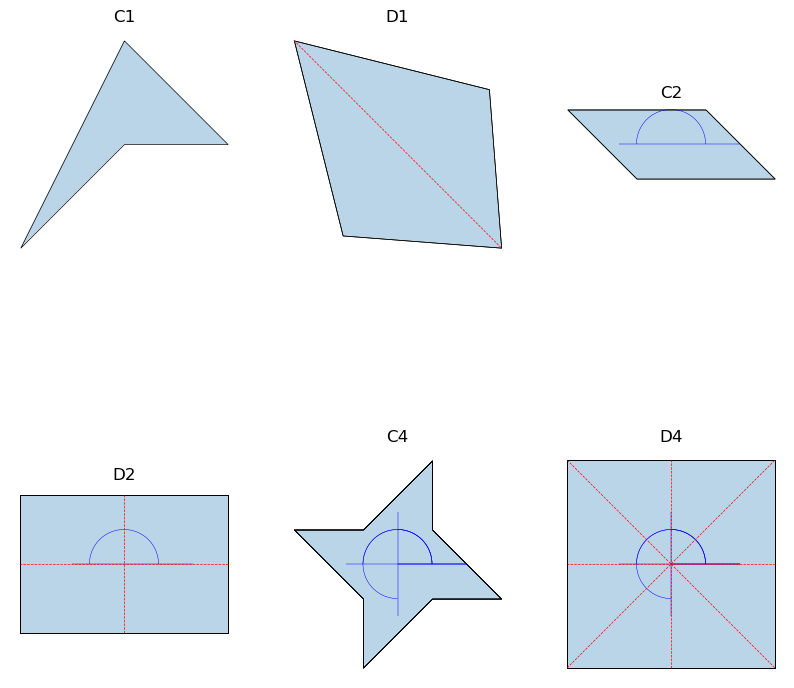

In [33]:
pt_sets = [
  [(50, 50), (150, -50), (50, -50), (-50, -150)], # irregular     C1
  [(30, 30), (35, -35), (-30, -30), (-50, 50)],   # kite          D1
  [(50, 50), (150, -50), (-50, -50), (-150, 50)], # parallelogram C2
  [(75, 50), (75, -50), (-75, -50), (-75, 50)],   # rectangle     D2
  [(50, 50), (150, -50), (50, -50), (-50, -150),  # star thing    C4
   (-50, -50), (-150, 50), (-50, 50), (50, 150)],
  [(50, 50), (50, -50), (-50, -50), (-50, 50)],   # square        D4
]
polys = [geom.Polygon(pts) for pts in pt_sets]
n = len(polys)
nc = int(np.ceil(np.sqrt(n)))
nr = int(np.ceil(n / nc))

fig = pyplot.figure(figsize = (10, 10))
for i, p in enumerate(polys):
  ax = fig.add_subplot(nr, nc, i + 1)
  gpd.GeoSeries([p]).plot(ax = ax, alpha = 0.3)
  s = Symmetries(p)
  ax.set_title(s.symmetry_group)
  for s in s.symmetries:
    s.plot(ax, p)
  pyplot.axis("off")

So... cyclic symmetries Cn may exist independent of reflection symmetries. But reflection symmetries only exist in pairs with corresponding number of rotational symmetries. This means that there should be a logic in the symmetry detection code like

However... if the question is one of matching a polygon to some other polygon (not finding the 'internal' symmetries of a polygon), then it is possible for the matching transform to be a reflection; it could also be a rotation at the same time, but a standalone reflection becomes a possibility for a shape with C1 as its symmetry group.

Make a C1 polygon and its mirror image - note we have to `shapely.normalize` the affine transformed shape because `shapely` reverses its winding order.

In [9]:
poly1 = affine.scale(tiling_utils.get_regular_polygon(500, 6), 1, 1)
p0 = tiling_utils.get_corners(poly1)[0]
poly2 = affine.translate(affine.rotate(poly1, 120, p0), 0, 0)

In [15]:
matcher = Shape_Matcher(poly1)
trs = matcher.get_polygon_matches(poly2)
trs["symmetries"]

One of the rotation matches is a translation.


[Transform(transform_type='rotation', angle=-119.99999998764929, centre=<POINT (-144.338 -250)>, translation=(0, 0), transform=[-0.499999999813319, 0.8660254038922189, -0.8660254038922189, -0.499999999813319, 6.077804073356674e-07, -499.9999998980064]),
 Transform(transform_type='rotation', angle=-60.00000010023976, centre=<POINT (0 -500)>, translation=(0, 0), transform=[0.49999999848487664, 0.8660254046591955, -0.8660254046591955, 0.49999999848487664, 433.0127006252431, -250.00000034082038]),
 Transform(transform_type='translation', angle=None, centre=None, translation=(433.012702, 250.0), transform=(1, 0, 0, 1, 433.012702, 250.0)),
 Transform(transform_type='rotation', angle=60.000000079769904, centre=<POINT (-433.013 250)>, translation=(0, 0), transform=[0.49999999879427826, -0.8660254044805624, 0.8660254044805624, 0.49999999879427826, -1.4364050002768636e-06, 499.99999963482543]),
 Transform(transform_type='rotation', angle=120.00000031306996, centre=<POINT (-288.675 0)>, translati

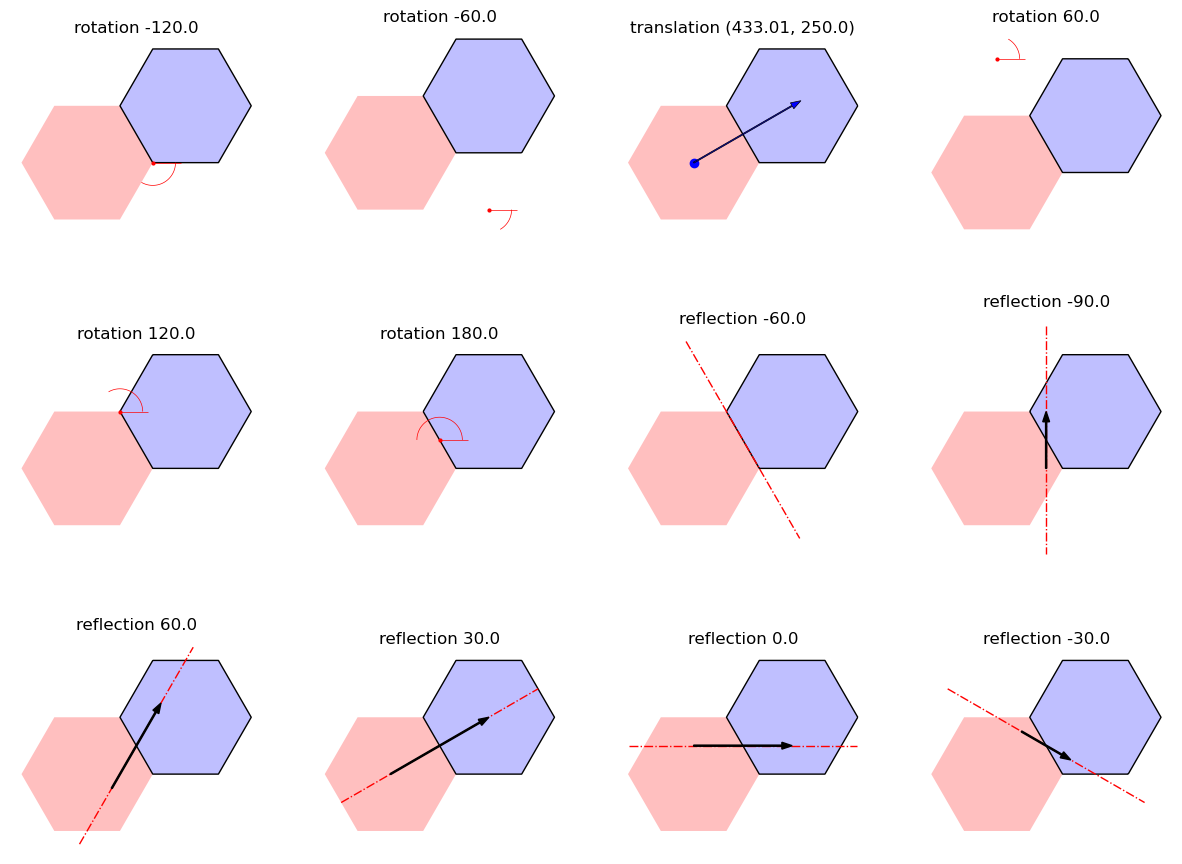

In [19]:
n = len(trs["symmetries"])
nc = int(np.ceil(np.sqrt(n)))
nr = int(np.ceil(n / nc))

fig = pyplot.figure(figsize = (15, 15 * nr/nc))

for i, tr in enumerate(trs["symmetries"]):
  ax = fig.add_subplot(nr, nc, i + 1)
  gpd.GeoSeries(
  [poly1, poly2, affine.affine_transform(poly2, tr.transform)]).plot(
    ax = ax, fc = ["#0000ff40", "#ff000040", "#00000000"], lw = [0, 0, 1], 
    ec = "k")
  if tr.transform_type == "rotation":
    tr.draw(ax, radius = 100)
  elif tr.transform_type == "reflection":
    tr.draw(ax, w = 5, mirror_length = 1000)
  elif tr.transform_type == "translation":
    tr.draw(ax, c = poly2.centroid)
  elif tr.transform_type == "identity":
    tr.draw(ax)
  pyplot.axis("off")
